In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.misc as misc
import skimage.io as io
import skimage.transform as transform
import time

from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix

from nearest_neighbors import KNNClassifier
from cross_validation import kfold, mod_kfold, knn_cross_val_score, knn_cross_val_score_mod
from my_tools import plot_confusion_matrix

%matplotlib inline

In [3]:
mnist = fetch_mldata("MNIST original")

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X = mnist.data
y = mnist.target

## Experiment 1

Разобьем датасет на обучающую выборку (60000 объектов) и тестовую выборку (10000 объектов)

In [6]:
# indices = np.arange(mnist.data.shape[0])
# np.random.shuffle(indices)

TRAIN_LENGTH = 60000
X_train = X[:TRAIN_LENGTH]
X_test = X[TRAIN_LENGTH:]
y_train = y[:TRAIN_LENGTH]
y_test = y[TRAIN_LENGTH:]

In [79]:
knn_my_own = KNNClassifier(5, strategy='my_own', metric='euclidean', weights=False, test_block_size=256)
knn_brute = KNNClassifier(5, strategy='brute', metric='euclidean', weights=False, test_block_size=256)
knn_kd_tree = KNNClassifier(5, strategy='kd_tree', metric='euclidean', weights=False, test_block_size=256)
knn_ball_tree = KNNClassifier(5, strategy='ball_tree', metric='euclidean', weights=False, test_block_size=256)

knns = [
    ("my_own", knn_my_own),
    ("brute", knn_brute),
    ("kd_tree", knn_kd_tree),
    ("ball_tree", knn_ball_tree)
]

In [80]:
mega_start_time = time.time()
for feature_num in [10, 20, 100]:
    print("Number of features: {}".format(feature_num))
    
    features_indices = np.arange(X_train.shape[1])
    np.random.shuffle(features_indices)
    features_indices = features_indices[:feature_num]
    
    for name, knn in knns:
        print("{}:".format(name))
        start_time = time.time()
        knn.fit(X_train[:, features_indices], y_train)
        print("fit: {:.2f} s".format(time.time() - start_time))
        start_time = time.time()
        kneighbors = knn.find_kneighbors(X_test[:, features_indices], False)
        print("neighbors search: {:.2f} s".format(time.time() - start_time))
print("It took {:.2f} seconds".format(time.time() - mega_start_time))

Number of features: 10
my_own:
fit: 0.13 s
neighbors search: 32.46 s
brute:
fit: 0.01 s
neighbors search: 31.87 s
kd_tree:
fit: 5.89 s
neighbors search: 1.27 s
ball_tree:
fit: 6.65 s
neighbors search: 5.91 s
Number of features: 20
my_own:
fit: 0.01 s
neighbors search: 36.27 s
brute:
fit: 0.01 s
neighbors search: 27.86 s
kd_tree:
fit: 4.48 s
neighbors search: 4.38 s
ball_tree:
fit: 3.37 s
neighbors search: 29.09 s
Number of features: 100
my_own:
fit: 0.07 s
neighbors search: 83.74 s
brute:
fit: 0.06 s
neighbors search: 31.09 s
kd_tree:
fit: 13.56 s
neighbors search: 103.83 s
ball_tree:
fit: 13.45 s
neighbors search: 103.28 s
It took 538.80 seconds


## Experiment 2-3

Euclidean, nonweighted

In [158]:
k_list = list(range(1, 11))

In [159]:
start_time = time.time()
accuracies_euclidean = knn_cross_val_score(
    X_train, y_train, k_list,
    "accuracy", kfold(X_train.shape[0], 3),
    metric="euclidean", weights=False
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 464.46 s


In [160]:
accuracies_euclidean

{1: [0.96879999999999999, 0.97224999999999995, 0.96794999999999998],
 2: [0.96189999999999998, 0.96389999999999998, 0.96109999999999995],
 3: [0.96845000000000003, 0.97240000000000004, 0.96924999999999994],
 4: [0.96630000000000005, 0.97004999999999997, 0.96765000000000001],
 5: [0.96784999999999999, 0.97009999999999996, 0.96860000000000002],
 6: [0.96579999999999999, 0.96924999999999994, 0.96679999999999999],
 7: [0.96504999999999996, 0.96830000000000005, 0.96645000000000003],
 8: [0.96489999999999998, 0.9667, 0.9657],
 9: [0.9647, 0.96684999999999999, 0.96565000000000001],
 10: [0.96340000000000003, 0.96555000000000002, 0.96414999999999995]}

In [161]:
for k, scores in accuracies_euclidean.items():
    print("{}: {:.4f}".format(k, np.array(scores).mean()))

1: 0.9697
2: 0.9623
3: 0.9700
4: 0.9680
5: 0.9688
6: 0.9673
7: 0.9666
8: 0.9658
9: 0.9657
10: 0.9644


Cosine, nonweighted

In [162]:
start_time = time.time()
accuracies_cosine = knn_cross_val_score(
    X_train, y_train, k_list,
    "accuracy", kfold(X_train.shape[0], 3),
    metric="cosine", weights=False
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 721.71 s


In [163]:
accuracies_cosine

{1: [0.97529999999999994, 0.97245000000000004, 0.97219999999999995],
 2: [0.97219999999999995, 0.96884999999999999, 0.96709999999999996],
 3: [0.97560000000000002, 0.97355000000000003, 0.97094999999999998],
 4: [0.97540000000000004, 0.97275, 0.97019999999999995],
 5: [0.97409999999999997, 0.97240000000000004, 0.97060000000000002],
 6: [0.97494999999999998, 0.97155000000000002, 0.96975],
 7: [0.97424999999999995, 0.97055000000000002, 0.96904999999999997],
 8: [0.97275, 0.96945000000000003, 0.96845000000000003],
 9: [0.97265000000000001, 0.96914999999999996, 0.96819999999999995],
 10: [0.97184999999999999, 0.96889999999999998, 0.96814999999999996]}

In [164]:
for k, scores in accuracies_cosine.items():
    print("{}: {:.4f}".format(k, np.array(scores).mean()))

1: 0.9733
2: 0.9694
3: 0.9734
4: 0.9728
5: 0.9724
6: 0.9721
7: 0.9713
8: 0.9702
9: 0.9700
10: 0.9696


Euclidean, weighted

In [165]:
start_time = time.time()
accuracies_euclidean_weighted = knn_cross_val_score(
    X_train, y_train, k_list,
    "accuracy", kfold(X_train.shape[0], 3),
    metric="euclidean", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 463.53 s


In [166]:
accuracies_euclidean_weighted

{1: [0.97050000000000003, 0.96794999999999998, 0.97030000000000005],
 2: [0.97050000000000003, 0.96794999999999998, 0.97030000000000005],
 3: [0.97124999999999995, 0.97045000000000003, 0.97109999999999996],
 4: [0.97119999999999995, 0.97109999999999996, 0.97204999999999997],
 5: [0.96945000000000003, 0.97014999999999996, 0.97014999999999996],
 6: [0.97089999999999999, 0.97094999999999998, 0.97009999999999996],
 7: [0.96799999999999997, 0.96784999999999999, 0.96804999999999997],
 8: [0.96870000000000001, 0.96855000000000002, 0.96845000000000003],
 9: [0.96740000000000004, 0.96704999999999997, 0.96709999999999996],
 10: [0.96730000000000005, 0.96704999999999997, 0.96704999999999997]}

In [167]:
for k, scores in accuracies_euclidean_weighted.items():
    print("{}: {:.4f}".format(k, np.array(scores).mean()))

1: 0.9696
2: 0.9696
3: 0.9709
4: 0.9714
5: 0.9699
6: 0.9707
7: 0.9680
8: 0.9686
9: 0.9672
10: 0.9671


Cosine, nonweighted

In [171]:
start_time = time.time()
accuracies_cosine_weighted = knn_cross_val_score(
    X_train, y_train, k_list,
    "accuracy", kfold(X_train.shape[0], 3),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 761.76 s


In [169]:
accuracies_cosine_weighted

{1: [0.97045000000000003, 0.96879999999999999, 0.96945000000000003],
 2: [0.97045000000000003, 0.96879999999999999, 0.96945000000000003],
 3: [0.97175, 0.96975, 0.97004999999999997],
 4: [0.97370000000000001, 0.97070000000000001, 0.97065000000000001],
 5: [0.97175, 0.96945000000000003, 0.96884999999999999],
 6: [0.97224999999999995, 0.96945000000000003, 0.96909999999999996],
 7: [0.97014999999999996, 0.96750000000000003, 0.96665000000000001],
 8: [0.97075, 0.96735000000000004, 0.96745000000000003],
 9: [0.96899999999999997, 0.96614999999999995, 0.96504999999999996],
 10: [0.96865000000000001, 0.96645000000000003, 0.96445000000000003]}

In [170]:
for k, scores in accuracies_cosine_weighted.items():
    print("{}: {:.4f}".format(k, np.array(scores).mean()))

1: 0.9696
2: 0.9696
3: 0.9705
4: 0.9717
5: 0.9700
6: 0.9703
7: 0.9681
8: 0.9685
9: 0.9667
10: 0.9665


## Experiment 4

In [36]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

In [37]:
best_knn.fit(X_train, y_train)

In [38]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 64.84 s


In [39]:
accuracy = (y_pred == y_test).sum() / y_test.shape[0]

In [40]:
print("accuracy: {}".format(accuracy))

accuracy: 0.9752


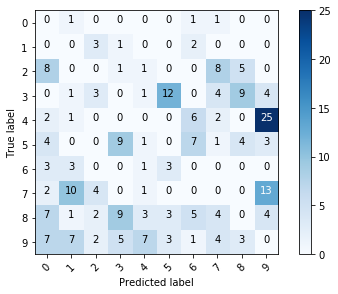

In [41]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_1.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

In [15]:
X_inaccurate = X_test[y_test != y_pred]
y_test_inaccurate = y_test[y_test != y_pred]
y_pred_inaccurate = y_pred[y_test != y_pred]

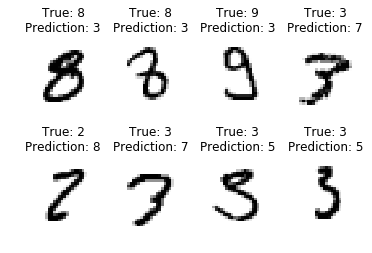

In [51]:
# images_true_pred = list(zip(X_inaccurate, y_test_inaccurate, y_pred_inaccurate))
# np.random.shuffle(images_true_pred)
for index, (image, true, prediction) in enumerate(itp1[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r)
    plt.title('True: {}\nPrediction: {}'.format(int(true), int(prediction)))

plt.show()

In [178]:
my_itp = [
    (X_4_9[16], 4, 9), (X_4_9[3], 4, 9), (X_7_9[4], 7, 9), (X_3_5[4], 3, 5),
    (X_7_1[7], 7, 1), images_true_pred[4], images_true_pred[5], images_true_pred[6]
] 

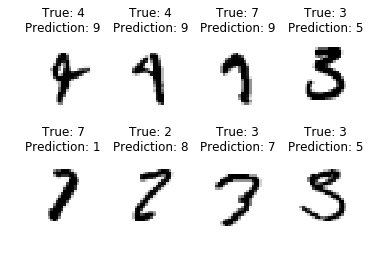

In [180]:
for index, (image, true, prediction) in enumerate(my_itp[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r)
    plt.title('True: {}\nPrediction: {}'.format(int(true), int(prediction)))

plt.savefig("err_1.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

In [92]:
X_4_9 = X_inaccurate[(y_test_inaccurate == 4) * (y_pred_inaccurate == 9)]

In [125]:
X_7_9 = X_inaccurate[(y_test_inaccurate == 7) * (y_pred_inaccurate == 9)]

In [149]:
X_3_5 = X_inaccurate[(y_test_inaccurate == 3) * (y_pred_inaccurate == 5)]

In [167]:
X_7_1 = X_inaccurate[(y_test_inaccurate == 7) * (y_pred_inaccurate == 1)]

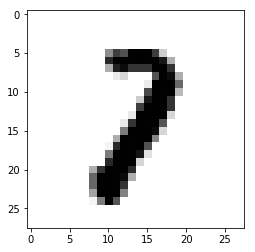

In [176]:
plt.imshow(X_7_1[7].reshape((28, 28)), cmap=plt.cm.gray_r)

In [46]:
itp1 = images_true_pred[:8]

## Experiment 5

Cosine weighted

In [5]:
X_test = X[60000:]
y_test = y[60000:]

train_inds = np.arange(60000)
np.random.shuffle(train_inds)
train_inds = train_inds[:12000]
#for i in range(10):
#    train_inds = np.r_[train_inds, np.arange(i * 6000 + 300 * i, i * 6000 + 2000 + 300 * i)]

X_train = X[train_inds]
y_train = y[train_inds]

(array([ 6903.,  7877.,  6990.,  7141.,  6824.,  6313.,  6876.,  7293.,
         6825.,  6958.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

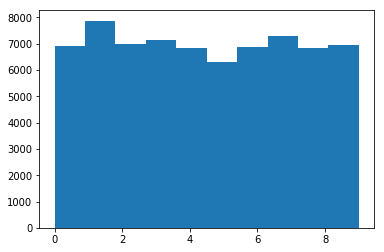

In [6]:
plt.hist(y)

In [7]:
folds = kfold(X_train.shape[0], 3)

In [8]:
k_list = range(1, 10)

In [9]:
start_time = time.time()
accuracies_cosine_weighted = knn_cross_val_score(
    X_train, y_train, k_list,
    "accuracy", folds,
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 5.47 s


In [10]:
for k, scores in accuracies_cosine_weighted.items():
    print("{}: {:.4f}".format(k, np.array(scores).mean()))

1: 0.9503
2: 0.9503
3: 0.9538
4: 0.9552
5: 0.9526
6: 0.9533
7: 0.9513
8: 0.9512
9: 0.9510


Degrees

5

In [11]:
X_train_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 5).ravel(),
    axis=1, arr=X_train
)

X_train_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -5).ravel(),
    axis=1, arr=X_train
)

In [12]:
X_train_modified = np.vstack((X_train, X_train_rotated_ccw, X_train_rotated_cw))

In [13]:
y_train_modified = np.hstack((y_train, y_train, y_train))

In [14]:
start_time = time.time()
accuracies_rotated_5_12k = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 3),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 49.03 s


In [15]:
print("Accuracy: {}".format(np.array(accuracies_rotated_5_12k[4]).mean()))

Accuracy: 0.9609166666666668


In [16]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [17]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 35.64 s


In [18]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9691


10

In [19]:
X_train_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    axis=1, arr=X_train
)

X_train_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel(),
    axis=1, arr=X_train
)

In [20]:
X_train_modified = np.vstack((X_train, X_train_rotated_ccw, X_train_rotated_cw))

In [21]:
y_train_modified = np.hstack((y_train, y_train, y_train))

In [22]:
start_time = time.time()
accuracies_rotated_10_12k = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 3),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 47.34 s


In [23]:
print("Accuracy: {}".format(np.array(accuracies_rotated_10_12k[4]).mean()))

Accuracy: 0.9617222222222223


In [24]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [25]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 36.02 s


In [26]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9715


15

In [27]:
X_train_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 15).ravel(),
    axis=1, arr=X_train
)

X_train_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -15).ravel(),
    axis=1, arr=X_train
)

In [28]:
X_train_modified = np.vstack((X_train, X_train_rotated_ccw, X_train_rotated_cw))

In [29]:
y_train_modified = np.hstack((y_train, y_train, y_train))

In [30]:
start_time = time.time()
accuracies_rotated_15_12k = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 3),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 44.96 s


In [31]:
print("Accuracy: {}".format(np.array(accuracies_rotated_15_12k[4]).mean()))

Accuracy: 0.9599444444444445


In [32]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [33]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 36.91 s


In [34]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9702


Shift

1 px

In [35]:
X_train_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel(),
    axis=1, arr=X_train
)

In [36]:
X_train_modified = np.vstack((
    X_train,
    X_train_shifted_up,
    X_train_shifted_down,
    X_train_shifted_left,
    X_train_shifted_right,
))

In [37]:
y_train_modified = np.hstack((y_train, y_train, y_train, y_train, y_train))

In [38]:
start_time = time.time()
accuracies_shifted_1 = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 5),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 841.72 s


In [39]:
print("Accuracy: {}".format(np.array(accuracies_shifted_1[4]).mean()))

Accuracy: 0.95935


In [40]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [41]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 70.77 s


In [42]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9711


2 px

In [43]:
X_train_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-2, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [2, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -2]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 2]).ravel(),
    axis=1, arr=X_train
)

In [44]:
X_train_modified = np.vstack((
    X_train,
    X_train_shifted_up,
    X_train_shifted_down,
    X_train_shifted_left,
    X_train_shifted_right,
))

In [45]:
y_train_modified = np.hstack((y_train, y_train, y_train, y_train, y_train))

In [46]:
start_time = time.time()
accuracies_shifted_2 = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfoldfold(folds, 5),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 845.41 s


In [47]:
print("Accuracy: {}".format(np.array(accuracies_shifted_2[4]).mean()))

Accuracy: 0.9572833333333334


In [48]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [49]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 62.53 s


In [50]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9659


3 px

In [51]:
X_train_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-3, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [3, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -3]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 3]).ravel(),
    axis=1, arr=X_train
)

In [52]:
X_train_modified = np.vstack((
    X_train,
    X_train_shifted_up,
    X_train_shifted_down,
    X_train_shifted_left,
    X_train_shifted_right,
))

In [53]:
y_train_modified = np.hstack((y_train, y_train, y_train, y_train, y_train))

In [54]:
start_time = time.time()
accuracies_shifted_3 = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 5),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 701.83 s


In [55]:
print("Accuracy: {}".format(np.array(accuracies_shifted_3[4]).mean()))

Accuracy: 0.9557000000000001


In [56]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [57]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 59.65 s


In [58]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9645


Gaussian

$\sigma^2 = 0.5$

In [59]:
X_train_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 0.5 ** (1/2)).ravel(),
    axis=1, arr=X_train
)

In [60]:
X_train_modified = np.vstack((
    X_train,
    X_train_filtered,
))

In [61]:
y_train_modified = np.hstack((y_train, y_train))

In [62]:
start_time = time.time()
accuracies_filtered_1_12k = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 2),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 18.91 s


In [63]:
print("Accuracy: {}".format(np.array(accuracies_filtered_1_12k[4]).mean()))

Accuracy: 0.9605416666666665


In [64]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [65]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 23.38 s


In [66]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9695


$\sigma^2 = 1$

In [67]:
X_train_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1 ** (1/2)).ravel(),
    axis=1, arr=X_train
)

In [68]:
X_train_modified = np.vstack((
    X_train,
    X_train_filtered,
))

In [69]:
y_train_modified = np.hstack((y_train, y_train))

In [70]:
start_time = time.time()
accuracies_filtered_2_12k = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 2),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 18.83 s


In [71]:
print("Accuracy: {}".format(np.array(accuracies_filtered_2_12k[4]).mean()))

Accuracy: 0.96125


In [72]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [73]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 23.32 s


In [74]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9698


$\sigma^2 = 1.5$

In [75]:
X_train_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1.5 ** (1/2)).ravel(),
    axis=1, arr=X_train
)

In [76]:
X_train_modified = np.vstack((
    X_train,
    X_train_filtered,
))

In [77]:
y_train_modified = np.hstack((y_train, y_train))

In [78]:
start_time = time.time()
accuracies_filtered_3_12k = knn_cross_val_score(
    X_train_modified, y_train_modified, [4],
    "accuracy", mod_kfold(folds, 2),
    metric="cosine", weights=True
)
print("It took {:.2f} s".format(time.time() - start_time))

It took 18.76 s


In [79]:
print("Accuracy: {}".format(np.array(accuracies_filtered_3_12k[4]).mean()))

Accuracy: 0.9610833333333334


In [80]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [81]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 23.31 s


In [82]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9702


Final

In [91]:
X_train_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    axis=1, arr=X_train
)

X_train_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel(),
    axis=1, arr=X_train
)

X_train_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1 ** (1/2)).ravel(),
    axis=1, arr=X_train
)

In [92]:
X_train_modified = np.vstack((
    X_train,
    X_train_rotated_ccw,
    X_train_rotated_cw,
    X_train_shifted_up,
    X_train_shifted_down,
    X_train_shifted_left,
    X_train_shifted_right,
    X_train_filtered
))

In [98]:
X_train.shape

(60000, 784)

In [97]:
X_train_modified.shape

(480000, 784)

In [93]:
y_train_modified = np.hstack((y_train, y_train, y_train, y_train, y_train, y_train, y_train, y_train))

In [94]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)
best_knn.fit(X_train_modified, y_train_modified)

In [95]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 734.76 s


In [96]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9851


## Experiment 5.1

In [42]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

(a)

In [43]:
X_train_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    axis=1, arr=X_train
)

X_train_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel(),
    axis=1, arr=X_train
)

In [44]:
X_train_modified = np.vstack((
    X_train,
    X_train_rotated_ccw,
    X_train_rotated_cw
))

In [45]:
y_train_modified = np.hstack((y_train, y_train, y_train))

In [46]:
best_knn.fit(X_train_modified, y_train_modified)

In [47]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 187.27 s


In [48]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9813


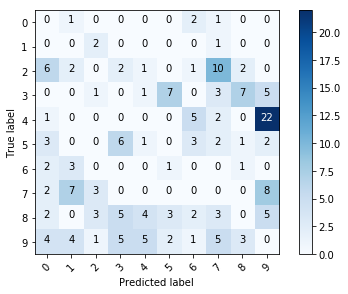

In [50]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_2.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

(b)

In [51]:
X_train_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    axis=1, arr=X_train
)

X_train_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel(),
    axis=1, arr=X_train
)

In [52]:
X_train_modified = np.vstack((
    X_train,
    X_train_shifted_up,
    X_train_shifted_down,
    X_train_shifted_left,
    X_train_shifted_right
))

In [53]:
y_train_modified = np.hstack((y_train, y_train, y_train, y_train, y_train))

In [54]:
best_knn.fit(X_train_modified, y_train_modified)

In [55]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 381.23 s


In [56]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9798


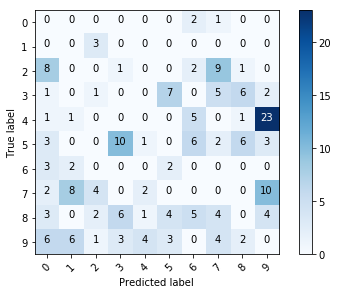

In [57]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_3.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

(c)

In [58]:
X_train_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1 ** (1/2)).ravel(),
    axis=1, arr=X_train
)

In [59]:
X_train_modified = np.vstack((
    X_train,
    X_train_filtered
))

In [60]:
y_train_modified = np.hstack((y_train, y_train))

In [61]:
best_knn.fit(X_train_modified, y_train_modified)

In [62]:
start_time = time.time()
y_pred = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 120.48 s


In [63]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9814


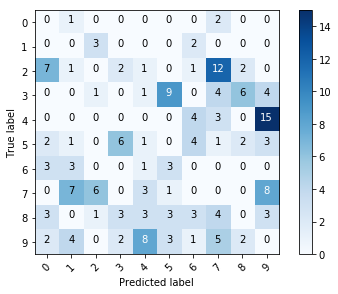

In [64]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_4.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

## Experiment 6

On 60k objs

In [7]:
X_test_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    axis=1, arr=X_test
)

X_test_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel(),
    axis=1, arr=X_test
)

X_test_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1 ** (1/2)).ravel(),
    axis=1, arr=X_test
)

In [8]:
X_test_set = [
    X_test, X_test_rotated_ccw, X_test_rotated_cw,
    X_test_shifted_up, X_test_shifted_down, X_test_shifted_left, X_test_shifted_right,
    X_test_filtered
]

In [10]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

In [12]:
best_knn.fit(X_train, y_train)

In [13]:
start_time = time.time()
y_pred = best_knn.predict_sets(X_test_set)
print("It took {:.2f} s".format(time.time() - start_time))

It took 412.41 s


In [14]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9701


In [15]:
start_time = time.time()
y_pred_nonfiltered = best_knn.predict(X_test)
print("It took {:.2f} s".format(time.time() - start_time))

It took 59.81 s


In [16]:
print("accuracy: {}".format((y_pred_nonfiltered == y_test).sum() / y_test.shape[0]))

accuracy: 0.9752


## Let's write cross validation!

In [11]:
X_test = X[60000:]
y_test = y[60000:]

train_inds = np.arange(60000)
np.random.shuffle(train_inds)
train_inds = train_inds[:12000]
#for i in range(10):
#    train_inds = np.r_[train_inds, np.arange(i * 6000 + 300 * i, i * 6000 + 2000 + 300 * i)]

X_train = X[train_inds]
y_train = y[train_inds]

(array([ 1233.,  1350.,  1180.,  1217.,  1163.,  1104.,  1173.,  1273.,
         1163.,  1144.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

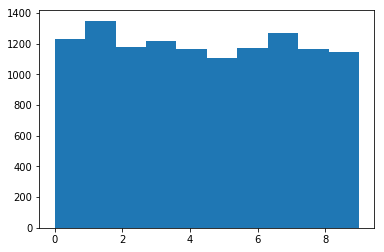

In [12]:
plt.hist(y_train)

### Non modified

In [36]:
start_time = time.time()
cv_score = knn_cross_val_score(X_train, y_train, [4], score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 5.09 s


In [38]:
print("Accuracy: {}".format(np.array(cv_score[4]).mean()))

Accuracy: 0.9594166666666667


### Degrees

$5^{\circ}$

In [16]:
mods = [
    lambda x: misc.imrotate(x.reshape((28, 28)), 5).ravel(),
    lambda x: misc.imrotate(x.reshape((28, 28)), -5).ravel()
]

In [19]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 16.84 s


In [20]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9655833333333333


$10^{\circ}$

In [21]:
mods = [
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel()
]

In [22]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 17.05 s


In [23]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9680833333333334


$15^{\circ}$

In [24]:
mods = [
    lambda x: misc.imrotate(x.reshape((28, 28)), 15).ravel(),
    lambda x: misc.imrotate(x.reshape((28, 28)), -15).ravel()
]

In [25]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 16.63 s


In [26]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9631666666666666


### Shifts

1 px

In [27]:
mods = [
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel()
]

In [28]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 29.97 s


In [29]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9680833333333334


2 px

In [30]:
mods = [
    lambda x: ndimage.shift(x.reshape((28, 28)), [-2, 0]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [2, 0]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -2]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 2]).ravel()
]

In [31]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 32.47 s


In [32]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9645833333333332


3 px

In [33]:
mods = [
    lambda x: ndimage.shift(x.reshape((28, 28)), [-3, 0]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [3, 0]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -3]).ravel(),
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 3]).ravel()
]

In [34]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 30.32 s


In [35]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9579166666666667


### Blur

$\sigma^2 = 0.5$

In [39]:
mods = [
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 0.5 ** (1/2)).ravel()
]

In [40]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 11.63 s


In [41]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9562499999999999


$\sigma^2 = 1$

In [43]:
mods = [
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1 ** (1/2)).ravel()
]

In [44]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 10.79 s


In [45]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.9460000000000001


$\sigma^2 = 1.5$

In [46]:
mods = [
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1.5 ** (1/2)).ravel()
]

In [47]:
start_time = time.time()
cv_score = knn_cross_val_score_mod(X_train, y_train, mods, 4, score='accuracy', metric="cosine", weights=True)
print("It took {:.2f} s".format(time.time() - start_time))

It took 10.80 s


In [48]:
print("Accuracy: {}".format(cv_score.mean()))

Accuracy: 0.93025


## Confusion matrix

In [50]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

(a)

In [57]:
X_test_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    axis=1, arr=X_test
)

X_test_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel(),
    axis=1, arr=X_test
)

In [58]:
X_test_set = [
    X_test, X_test_rotated_ccw, X_test_rotated_cw
]

In [59]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

In [60]:
best_knn.fit(X_train, y_train)

In [61]:
start_time = time.time()
y_pred = best_knn.predict_sets(X_test_set)
print("It took {:.2f} s".format(time.time() - start_time))

It took 168.68 s


In [62]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9802


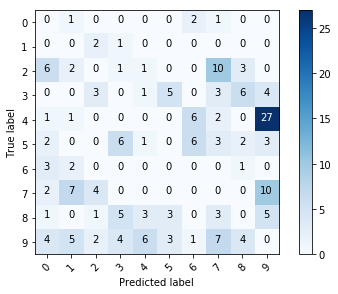

In [63]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_5.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

(b)

In [64]:
X_test_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel(),
    axis=1, arr=X_test
)

In [65]:
X_test_set = [
    X_test, X_test_shifted_up, X_test_shifted_down,
    X_test_shifted_left, X_test_shifted_right
]

In [66]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

In [69]:
best_knn.fit(X_train, y_train)

In [70]:
start_time = time.time()
y_pred = best_knn.predict_sets(X_test_set)
print("It took {:.2f} s".format(time.time() - start_time))

It took 225.47 s


In [71]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9798


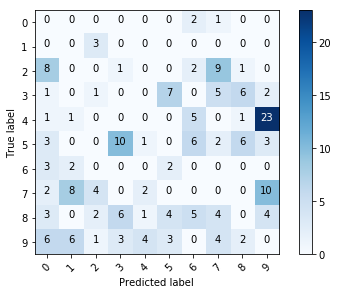

In [72]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_6.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

(c)

In [73]:
X_test_filtered = np.apply_along_axis(
    lambda x: ndimage.gaussian_filter(x.reshape((28, 28)), 1 ** (1/2)).ravel(),
    axis=1, arr=X_test
)

In [74]:
X_test_set = [
    X_test,
    X_test_filtered
]

In [75]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

In [76]:
best_knn.fit(X_train, y_train)

In [77]:
start_time = time.time()
y_pred = best_knn.predict_sets(X_test_set)
print("It took {:.2f} s".format(time.time() - start_time))

It took 85.59 s


In [78]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.9634


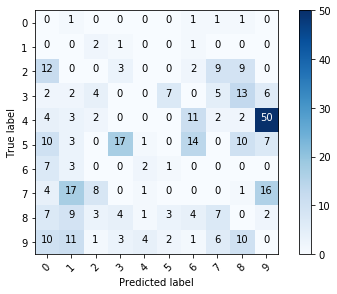

In [79]:
cm = confusion_matrix(y_test, y_pred)
cm[(np.arange(10), np.arange(10))] = 0
plot_confusion_matrix(cm, range(10), title='')
plt.savefig("cm_7.pdf", format='pdf', bbox_inches='tight', pad_inches=0.1)

Final

In [81]:
X_test_rotated_ccw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), 10).ravel(),
    axis=1, arr=X_test
)

X_test_rotated_cw = np.apply_along_axis(
    lambda x: misc.imrotate(x.reshape((28, 28)), -10).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_up = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [-1, 0]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_down = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [1, 0]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_left = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, -1]).ravel(),
    axis=1, arr=X_test
)

X_test_shifted_right = np.apply_along_axis(
    lambda x: ndimage.shift(x.reshape((28, 28)), [0, 1]).ravel(),
    axis=1, arr=X_test
)

In [83]:
X_test_set = [
    X_test,
    X_test_rotated_ccw, X_test_rotated_cw,
    X_test_shifted_up, X_test_shifted_down,
    X_test_shifted_left, X_test_shifted_right
]

In [84]:
best_knn = KNNClassifier(4, strategy="brute", metric="cosine", weights=True)

In [85]:
best_knn.fit(X_train, y_train)

In [86]:
start_time = time.time()
y_pred = best_knn.predict_sets(X_test_set)
print("It took {:.2f} s".format(time.time() - start_time))

It took 327.10 s


In [87]:
print("accuracy: {}".format((y_pred == y_test).sum() / y_test.shape[0]))

accuracy: 0.982
